In [1]:
import numpy as np
from scipy.optimize import fsolve
from brian2 import *
import matplotlib.pyplot as plt
import seaborn as sns

integration_method = 'exponential_euler'

In [2]:
def rasterplot(spikes, ax=None, offset=0, **kwargs):
    import matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()
    for i,spks in enumerate(spikes):
        ax.plot(spks, offset+i+np.zeros(len(spks)), '.', ms=1, **kwargs)

In [3]:
def F(i, taum, tarp=0*ms):
    if np.isscalar(i):
        if i <= 1:
            return 0*Hz
        return 1 / (tarp + taum*(np.log(i)-np.log(i-1)))
    nu = np.zeros_like(i) * Hz
    idx = i > 1
    nu[idx] = 1 / (tarp + taum*(np.log(i[idx])-np.log(i[idx]-1)))
    return nu

In [4]:
# neuron parameters
taum = 20*ms
tarp = 2*ms

# how many neurons
Ne = 10000
N_ext = 500

# synaptic parameters
taus = 5*ms
nu_ext = 5*Hz
J_ext = 0.1
p_rec = 0.1
J_rec = 0.001

In [5]:
i_ext_mean = N_ext * nu_ext * J_ext * taus
nu_0 = F(i_ext_mean, taum, tarp)
func = lambda ν: ν - F(N_ext*nu_ext*J_ext*taus + p_rec*Ne*J_rec*taus*ν*Hz, taum, tarp)/Hz
nu_mean, = fsolve(func, nu_0/Hz)
print('Mean external synaptic current: {:g}.'.format(i_ext_mean))
print('Mean firing rate: {:g} spikes/s.'.format(nu_mean))

Mean external synaptic current: 1.25.
Mean firing rate: 39.1707 spikes/s.


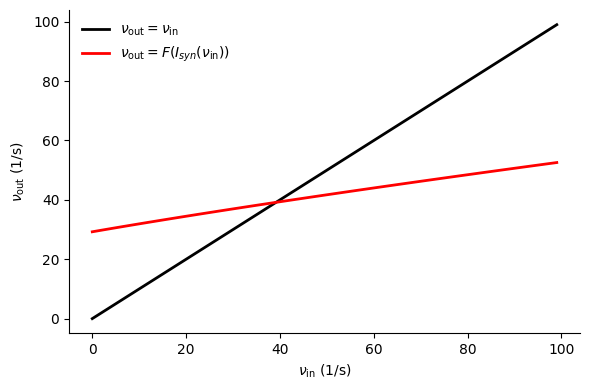

In [6]:
ν = np.r_[0 : 100] * Hz
y = F(N_ext*nu_ext*J_ext*taus + p_rec*Ne*J_rec*taus*ν, taum, tarp)
fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(ν, ν, 'k', lw=2, label=r'$\nu_{\mathrm{out}}=\nu_{\mathrm{in}}$')
ax.plot(ν, y, 'r', lw=2, label=r'$\nu_{\mathrm{out}}=F(I_{syn}(\nu_{\mathrm{in}}))$')
ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.set_xlabel(r'$\nu_{\mathrm{in}}$ (1/s)')
ax.set_ylabel(r'$\nu_{\mathrm{out}}$ (1/s)')
sns.despine()
fig.tight_layout()

In [7]:
neuron_eqs = Equations("""
du/dt = (-u+i_syn)/taum : 1 (unless refractory)
i_syn = i_ext + i_rec : 1
di_ext/dt = -i_ext/taus : 1
di_rec/dt = -i_rec/taus : 1
""")
thresh_cond = 'u>1'
reset_action= 'u=0'

In [8]:
neurons = NeuronGroup(Ne, neuron_eqs, threshold=thresh_cond, reset=reset_action,
                      refractory=tarp, method=integration_method, name='neuron')
neurons.u = 0

In [9]:
synapses = Synapses(neurons, neurons, model='wee: 1', on_pre='i_rec += wee', delay=1*ms,
                    method=integration_method, name='synapses')
synapses.connect(p=p_rec)
synapses.wee = J_rec

In [10]:
poisson_ext = PoissonInput(neurons, 'i_ext', N_ext, nu_ext, J_ext)

In [11]:
post_spike_mon = SpikeMonitor(neurons)
state_mon = StateMonitor(neurons, ['u','i_ext', 'i_rec'], record=True)

In [12]:
tend = 500*ms
run(tend)

In [13]:
t = state_mon.t / ms
u = state_mon.u[0]
i_ext = state_mon.i_ext[0]
i_rec = state_mon.i_rec[0]

In [14]:
spike_times = post_spike_mon.t/second
bin_size = taus/second
edges = np.r_[0 : tend/second : bin_size]
n_spikes,_ = np.histogram(spike_times, edges)
nu = n_spikes / bin_size / Ne

In [15]:
spks = []
for i in range(50):
    idx = post_spike_mon.i == i
    spks.append(spike_times[idx]*1e3)

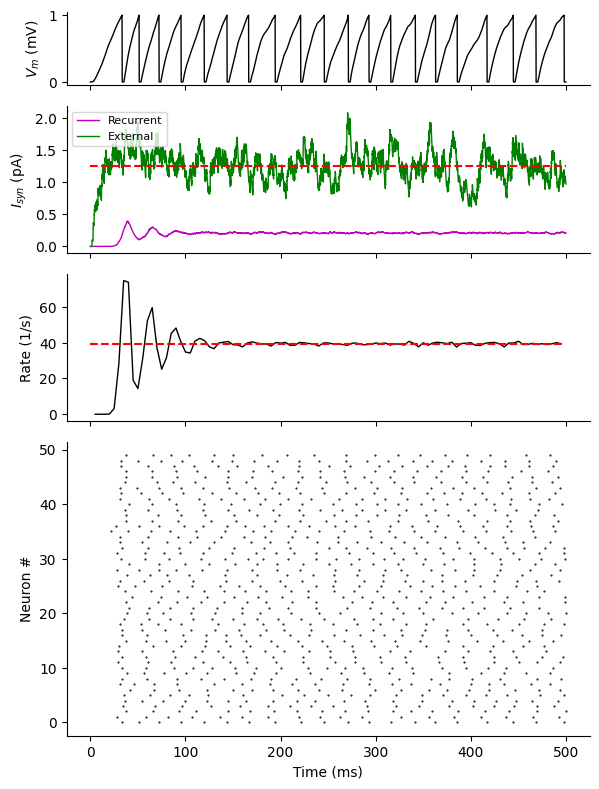

In [16]:
fig,ax = plt.subplots(4, 1, figsize=(6,8), height_ratios=(0.5,1,1,2), sharex=True)
ax[0].plot(t, u, 'k', lw=1)
ax[1].plot(t, i_rec, 'm', lw=1, label='Recurrent')
ax[1].plot(t, i_ext, 'g', lw=1, label='External')
ax[1].plot(t[[0,-1]], i_ext_mean+np.zeros(2), 'r--')
ax[2].plot(edges[1:]*1e3, nu, 'k', lw=1)
ax[2].plot(edges[[0,-1]]*1e3, nu_mean+np.zeros(2), 'r--')
rasterplot(spks, ax=ax[3], color='k')
ax[0].set_ylabel(r'$V_m$ (mV)')
ax[1].set_ylabel(r'$I_{syn}$ (pA)')
ax[2].set_ylabel('Rate (1/s)')
ax[3].set_ylabel('Neuron #')
ax[-1].set_xlabel('Time (ms)')
ax[1].legend(loc='upper left', frameon=True, fontsize=8)
sns.despine()
fig.tight_layout()
plt.savefig('recurrent_net.png')